## Prerequisites

The libraries that are needed in order for the project to work

In [1]:
import numpy as np # Working with tensors

In [2]:
import sounddevice # Recording audio

In [3]:
import matplotlib.pyplot as plt # Data visualization

In [4]:
import seaborn as sns # For easier visualization in certain places

In [5]:
import os # Managing dataset files

In [6]:
import librosa # Audio processing

In [7]:
import pandas as pd # For dataframes

In [8]:
import tensorflow as tf # NN framework

2024-11-21 01:29:52.964819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732141793.066563   47426 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732141793.097414   47426 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 01:29:53.314421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from IPython.display import Audio # For an audio widget inside of the notebook

In [10]:
from types import MappingProxyType # Immutable dictionary

## Constants

In [11]:
STR_TO_EMOTION = MappingProxyType({
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
})

STR_TO_INTENSITY = MappingProxyType({
    '01': 'normal',
    '02': 'strong',
})

def get_speaker_gender(str):
    return 'female' if int(str) % 2 == 0  else 'male'

## Configuration

All the variable parameters to tweak the model should be included here

In [12]:
# All audio captures are using/converted to this sample rate first to reduce noises and increase performance
resampling_value = 3000

chunk_seconds = 0.2 # How long should the audio captures be before feeding them to the network
input_size = int(chunk_seconds * resampling_value) # How many ints are needed to store one chunk

split_overlap = 0.1 # How big is the overlap between dataset samples when splitting them into chunks

n_mfcc = 50 # The number of features produced by MFCC calculation
n_fft = 512 # Window size for the fast transform

## Recording audio in real-time into a NumPy array (TODO after the first functional model is done)

In [13]:
# Main loop of the app goes here
for i in range(1):
    recording = sounddevice.rec(input_size, samplerate=resampling_value, channels=2)
    sounddevice.wait()
    print(len(recording))

600


## Dataset preprocessing (RAVDESS)

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

> The dataset has been downloaded as a .zip archive from
>
>
> https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
>
>
> Folders Actor 1 ... 24 were then unpacked to the `./research/dataset/` directory of the project

### Loading the data

In [14]:
recording_paths = []
labels = []

In [15]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        if filename == '.gitignore': continue
        recording_params = filename[:-4].split('-')
        recording_paths.append(os.path.join(dirname, filename))
        label = [get_speaker_gender(dirname[-2:]), STR_TO_EMOTION[recording_params[2]], STR_TO_INTENSITY[recording_params[3]]]
        labels.append(label)

In [16]:
pd.DataFrame(data={'source_file': recording_paths, 'labels': labels})

,source_file,labels
0,./dataset/Actor_15/03-01-07-02-02-02-15.wav,"[male, disgust, strong]"
1,./dataset/Actor_15/03-01-06-01-01-02-15.wav,"[male, fearful, normal]"
2,./dataset/Actor_15/03-01-04-02-01-01-15.wav,"[male, sad, strong]"
3,./dataset/Actor_15/03-01-04-01-01-02-15.wav,"[male, sad, normal]"
4,./dataset/Actor_15/03-01-02-02-02-01-15.wav,"[male, calm, strong]"
...,...,...
1435,./dataset/Actor_06/03-01-05-02-01-02-06.wav,"[female, angry, strong]"
1436,./dataset/Actor_06/03-01-05-01-02-02-06.wav,"[female, angry, normal]"
1437,./dataset/Actor_06/03-01-06-02-02-02-06.wav,"[female, fearful, strong]"
1438,./dataset/Actor_06/03-01-04-01-01-01-06.wav,"[female, sad, normal]"


Checking if the dataset is balanced across the classes:

<Axes: xlabel='count'>

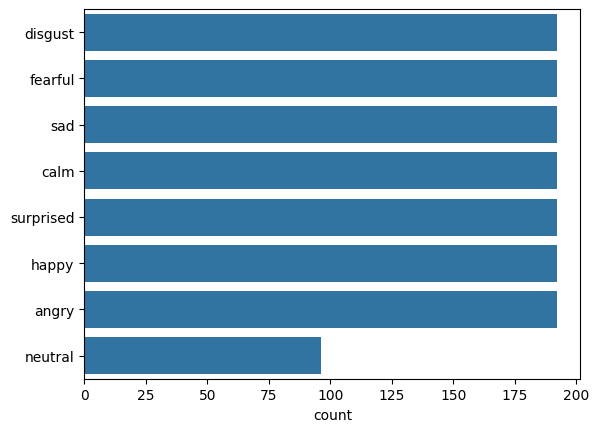

In [17]:
sns.countplot([label[1] for label in labels]) # How many samples of each emotion are there

> Neutral emotion has half the samples since it does not have an intense expression, dataset balancing may be required

## The data

### Snippets

In [18]:
# Resample audio to a specified sample rate of resampling_value
def resample(data, orig_sr):
    return librosa.resample(data, orig_sr=orig_sr, target_sr=resampling_value)

### Observing the data

In [19]:
framed_samples = {} # Contains one frame for each comnbination of labels to observe the data

In [20]:
for (file_path, label) in zip(recording_paths, labels):
    data, sampling_rate = librosa.load(file_path)
    resampled_data = resample(data, sampling_rate)
    
    frames = librosa.util.frame(resampled_data, frame_length=input_size, hop_length=int(input_size*split_overlap), axis=0)
    
    for frame in frames:
        if (str(label) not in framed_samples) and (np.sum(np.abs(frame)) > 0.01): # np.sum... to exclude mostly silent frames from observation
            framed_samples[str(label)] = frame

In [21]:
def extract_features(frame):
    frame_mel_adjusted = librosa.feature.melspectrogram(y=frame, sr=resampling_value)
    
    fig, ax = plt.subplots(nrows=3)
    fig.suptitle('Label: ' + str(label))
    
    ax[0].set(title='Mel power spectre')
    ax[1].set(title='Mel log-power spectre')
    ax[2].set(title='Mel cepstral coefficients')

    fig.tight_layout()
    
    power_spectre = librosa.display.waveplot(frame, sr=resampling_value, ax=ax[0])
    log_power_spectre = librosa.display.specshow(librosa.power_to_db(frame_mel_adjusted), y_axis='log', x_axis='time', sr=resampling_value, ax=ax[1])
    # mfcc = librosa.display.specshow(librosa.feature.mfcc(y=librosa.power_to_db(frame_mel_adjusted)), y_axis='log', x_axis='time', sr=resampling_value, ax=ax[2])


/home/maxim/miniconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(


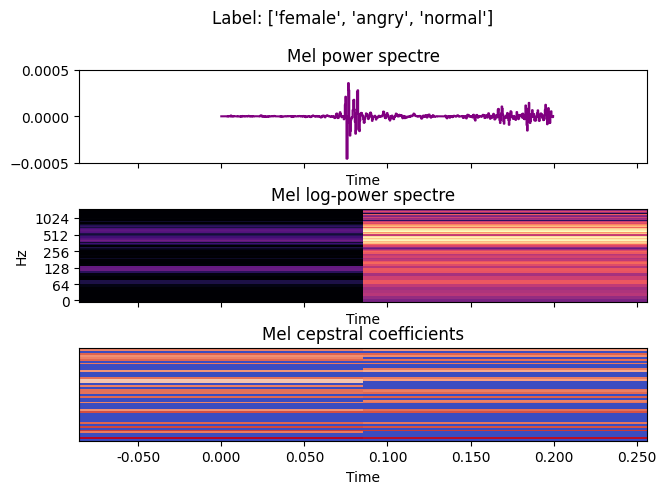

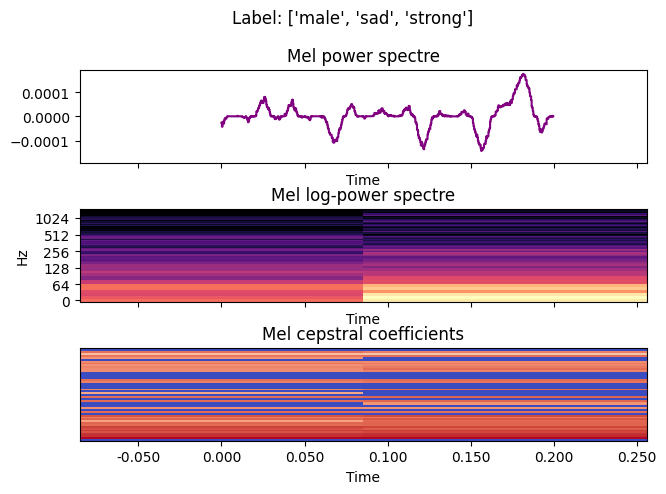

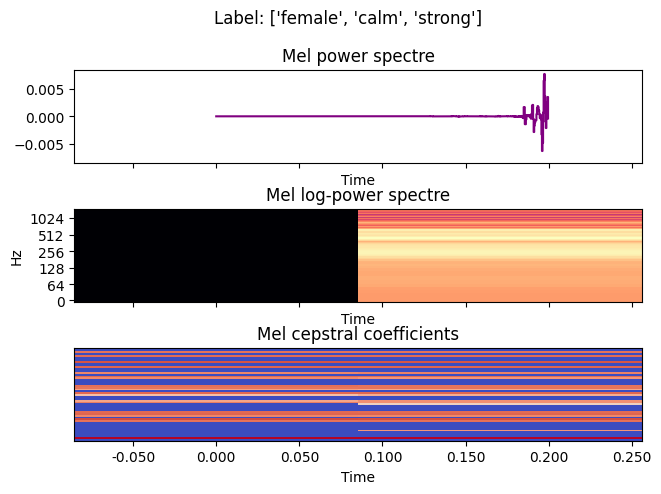

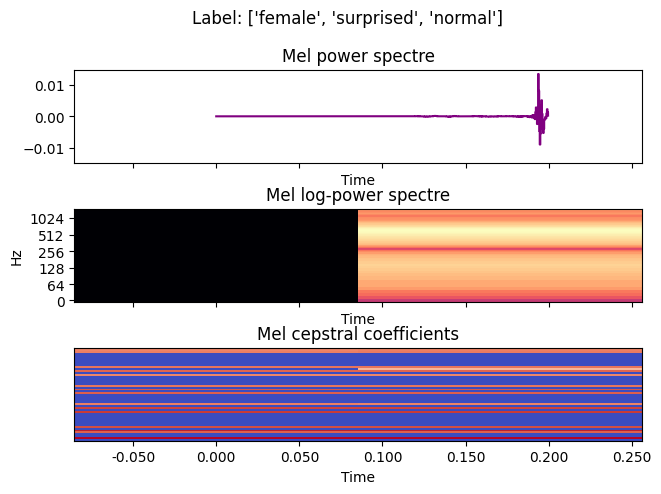

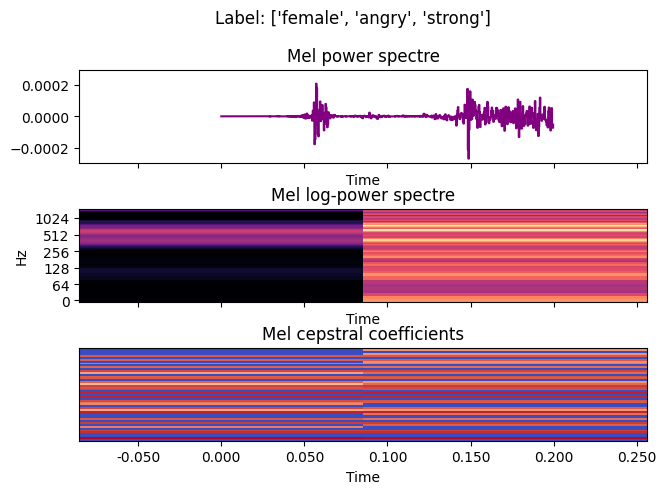

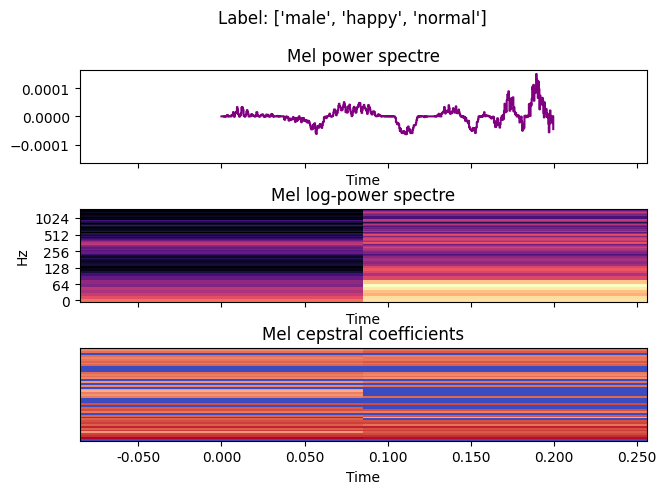

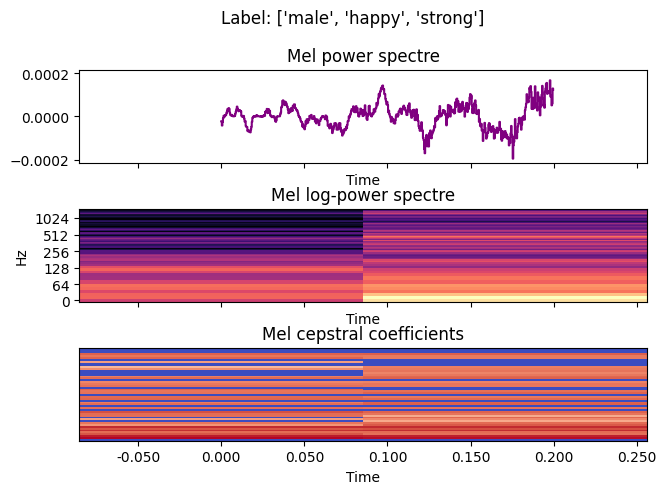

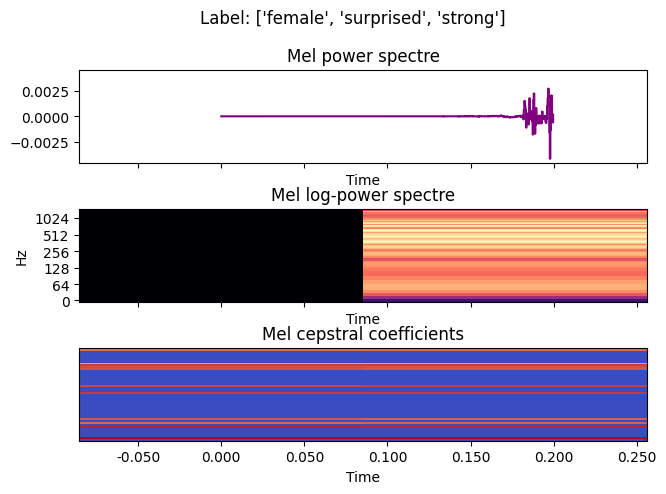

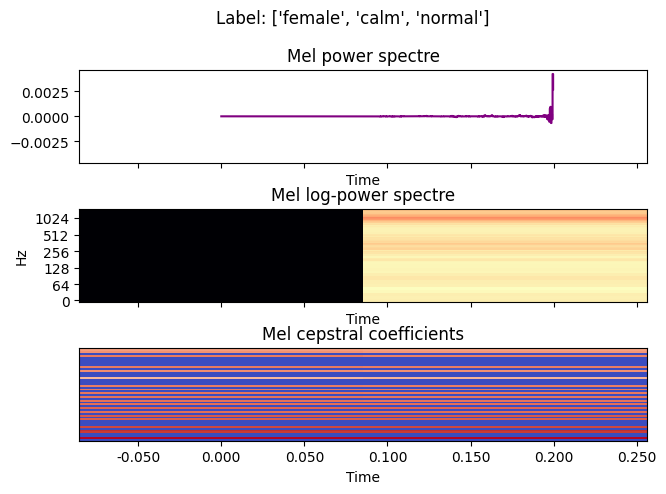

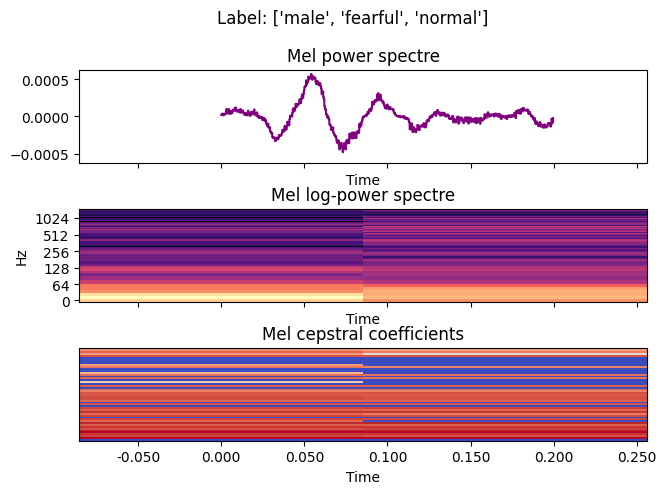

In [22]:
import random

show_first = 10 # Selects N random combinations of features from the dataset (max 30)

keys = list(framed_samples.keys())
random.shuffle(keys)

for key in keys[:show_first]:
    frame = framed_samples[key]
    
    frame_mel_adjusted = librosa.feature.melspectrogram(y=frame, sr=resampling_value, n_fft=n_fft)

    fig, ax = plt.subplots(nrows=3, sharex=True)
    fig.suptitle('Label: ' + key)
    
    ax[0].set(title='Mel power spectre')
    ax[1].set(title='Mel log-power spectre')
    ax[2].set(title='Mel cepstral coefficients')

    fig.tight_layout()
    
    time_amplitude =  librosa.display.waveshow(y=frame, sr=resampling_value, ax=ax[0], color='purple', transpose = False) # Color is explicitly specified to avoid librosa's bug 
    log_power_spectre = librosa.display.specshow(librosa.power_to_db(frame_mel_adjusted), y_axis='log', x_axis='time', sr=resampling_value, ax=ax[1])
    mfcc = librosa.display.specshow(librosa.power_to_db(librosa.feature.mfcc(y=frame, sr=resampling_value, n_mfcc=n_mfcc)), x_axis='time', sr=resampling_value, ax=ax[2], n_fft=n_fft)

### Preprocessing the data (TODO)

This includes loading the audio data, resampling, framing etc.

## Training the model (TODO)

In [23]:
model_data = []
for (file_path, label)  in zip(recording_paths, labels):
    data, sampling_rate = librosa.load(file_path)
    resampled_data = librosa.resample(data, orig_sr=sampling_rate, target_sr=resampling_value)

    frames = librosa.util.frame(resampled_data, frame_length=input_size, hop_length=int(input_size*split_overlap), axis=0)
    
    for frame in frames:
        model_data.append([frame, label[1]])

In [24]:
random.shuffle(model_data)

In [25]:
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [26]:
onehot_enc = tf.keras.utils.to_categorical([x for x in range(8)])

In [27]:
onehot_map = {emotion: encoding for emotion, encoding in zip(emotions, onehot_enc)}

In [28]:
for entry in model_data:
    entry[1] = onehot_map[entry[1]]

In [29]:
train_data = model_data[:int(len(model_data) * 0.7)]
validation_data = model_data[int(len(model_data) * 0.7):int(len(model_data) * 0.85)]
test_data = model_data[int(len(model_data) * 0.85):]

In [30]:
train_data_X = [entry[0] for entry in train_data]
train_data_Y = [entry[1] for entry in train_data]

validation_data_X = [entry[0] for entry in validation_data]
validation_data_Y = [entry[1] for entry in validation_data]

test_data_X = [entry[0] for entry in test_data]
test_data_Y = [entry[1] for entry in test_data]

In [31]:
print(np.array(train_data_Y).reshape(8, 176913).shape)

(8, 176913)


In [32]:
print(np.array(train_data_X).shape)

(176913, 600)


In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=8)
])

In [37]:
print(len(train_data_X), len(train_data_Y))

176913 176913


In [38]:
with tf.device('/cpu:0'): # '/gpu:0' for GPU
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(np.array(train_data_X), np.array(train_data_Y), epochs=5, batch_size=1, verbose=2)

Epoch 1/5
176913/176913 - 160s - 907us/step - loss: 0.1122
Epoch 2/5
176913/176913 - 160s - 904us/step - loss: 0.1123
Epoch 3/5
176913/176913 - 66s - 375us/step - loss: 0.1122
Epoch 4/5
176913/176913 - 67s - 380us/step - loss: 0.1122
Epoch 5/5
176913/176913 - 68s - 387us/step - loss: 0.1122
